In [76]:
from math import pi
import itertools as itt
from collections import defaultdict

import numpy as np

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import hex_to_rgb
from IPython.display import Image
from src.root_path import root_path

from src.data.rasters import load_site_formated_raster
from src.metrics.consolidated_tstat import tstat_cluster_mass
from src.metrics.significance import _significance

from src.visualization.fancy_plots import squarefy
from src.visualization.interactive import plot_raw_pair, plot_time_ser_quant
from src.visualization.palette import *

### Plotting parameters

# Panels

In [77]:
panels = defaultdict(list)

## sound sequences plus selected examples

In [78]:
# waveforms
n_samps = 100
dummy_wave = np.sin(np.linspace(0,pi*4,n_samps)) * 0.25 # todo, pull some real example waves??
waves = [np.zeros(n_samps)] + [dummy_wave, ] * 5 + [np.zeros(n_samps)]

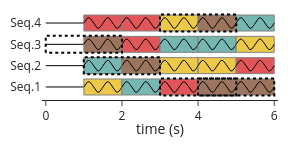

In [79]:
panelname = 'sequences'


sequences = np.asarray([[0,1,3,2,4,4],
                        [0,3,4,1,1,2],
                        [0,4,2,3,3,1],
                        [0,2,2,1,4,3]])
eg_probe = 4

colors = FOURCOLOR

xbox = np.asarray([0,1,1,0,0])
ybox = (np.asarray([0,0,1,1,0])-0.5) * 0.75

egbox_height = 0.8


fig = go.Figure()

for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        color = colors[wave_idx]
        if ww > 0:
            # Colored boxes except silence
            _ = fig.add_trace(go.Scatter(x=xbox+ww, y=ybox+ss, fill='toself',
                                         mode='lines',
                                         line=dict(width=1,
                                                   color='gray'),
                                         fillcolor=color,
                                         showlegend=False)
                              )

        # wave form plots
        x = np.linspace(0,1,n_samps) + ww
        y = waves[wave_idx] + ss
        _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                     line=dict(color='black',
                                               width=1),
                                     showlegend=False,
                                     )
                          )

# Add e.g. dotted boxes, ensure are the last to be drawn so they are on top
for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        if wave_idx == eg_probe:
            x0 = ww - 1
            y0 = ss - egbox_height/2
            xd, yd = 2, egbox_height  # 2 seconds widht, 2*norm wave
            x = [x0, x0, x0+xd, x0+xd, x0]
            y = [y0, y0+yd, y0+yd, y0, y0]
            _ =  fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                          line=dict(color='black',
                                                    width=2,
                                                    dash='dot'),
                                          showlegend=False,
                                          )
                               )

if panelname in panels:
    panels.pop(panelname)
panels[panelname].extend(fig['data'])

# test show
_ = fig.update_xaxes(title_text='time (s)', title_standoff=0, range=[-0.1,6.1])
_ = fig.update_yaxes(tickmode='array',
                     tickvals=list(range(4)),
                     ticktext=[f'Seq.{i+1}' for i in range(4)],
                     ticks='',
                     showline=False)
fig.update_layout(width=96*3, height=96*1.5,
                  margin={'l':10,'r':10,'t':10,'b':10,},
                  template='simple_white')
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)


### selected stimuli examples and transition type clasification

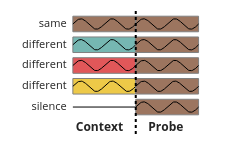

In [80]:
panelname = 'transitions'

fig = go.Figure()
xbox = np.asarray([0, 1, 1, 0, 0])
ybox = (np.asarray([0, 0, 1, 1, 0]) - 0.5) * 0.75

for ww, (wave, color) in enumerate(zip(waves, colors)):
    # context box
    if ww > 0: # omits silence box,
        _ = fig.add_trace(go.Scatter(x=xbox - 1, y=ybox + ww, fill='toself',
                                     mode='lines',
                                     line=dict(width=1,
                                               color='gray'),
                                     fillcolor=color,
                                     showlegend=False)
                          )
    # contex wave
    x = np.linspace(-1, 0, n_samps)  # sum to offset to center, insline with sequences
    y = wave + ww
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color='black',
                                           width=1, ),
                                 showlegend=False)
                      )

    # probe box
    _ = fig.add_trace(go.Scatter(x=xbox, y=ybox + ww, fill='toself',
                                 mode='lines',
                                 line=dict(width=1,
                                           color='gray'),
                                 fillcolor=colors[eg_probe],
                                 showlegend=False)
                      )
    # probe wave
    x = np.linspace(0, 1, n_samps)
    y = waves[eg_probe] + ww
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color='black',
                                           width=1, ),
                                 showlegend=False)
                      )
    # ax.plot(x, y, colors[prb_idx])

    # context type text
    if ww == 0:
        type_text = 'silence'
    elif ww == eg_probe:
        type_text = 'same'
    else:
        type_text = 'different'

    _ = fig.add_trace(go.Scatter(x=[-1.1], y=[ww],
                                 mode='text', text=[type_text],
                                 textposition='middle left', textfont_size=11,
                                 showlegend=False)
                      )

_ = fig.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1,
                  )
# context and probe text
_ = fig.add_trace(go.Scatter(x=[-0.2, 0.2],
                             y=[-1, -1],
                             mode='text', text=['<b>Context</b>', '<b>Probe</b>'],
                             textposition=['middle left', 'middle right'], textfont_size=12,
                             showlegend=False)
                  )

if panelname in panels:
    panels.pop(panelname)
panels[panelname].extend(fig['data'])

# test show
_ = fig.update_layout(width=96 * 2.5, height=96 * 1.5,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      xaxis=dict(range=[-2,1.5], visible=False),
                      yaxis=dict(visible=False))
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# example rasters and PSTHs
## example 1

In [81]:
# Example 1, same as the one used to define the examples
probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'

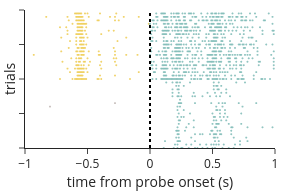

In [82]:
panelname = 'raster'
def formated_raster(cellid, ctx_pair, probe, panelname):
    fig = plot_raw_pair(cellid, ctx_pair, probe, type='raster', raster_fs=100)
    fig.update_traces(line=dict(width=1),
                      marker=dict(size=2,
                                  opacity=0.8,
                                  line=dict(width=0,)))

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(fig['data'])

    # test show
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False
                      )

    # fig.show()
    img_bytes = fig.to_image(format="png")
    return Image(img_bytes)

formated_raster(cellid, ctx_pair, probe, panelname)

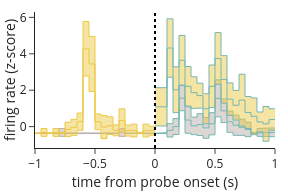

In [83]:
panelname = 'PSTH'
def formated_psth(cellid, ctx_pair, probe, panelname):
    fig = plot_raw_pair(cellid, ctx_pair, probe, raster_fs=20)
    fig.update_traces(line=dict(width=1))

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(fig['data'])

    # test showe
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False
                      )

    # fig.show()
    img_bytes = fig.to_image(format="png")
    return Image(img_bytes)
formated_psth(cellid, ctx_pair, probe, panelname)

### Cluster mass signficance and difference quantification

using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 4774.57 d'*ms
center of mass: 370.79 ms
last bin: 900.00 ms


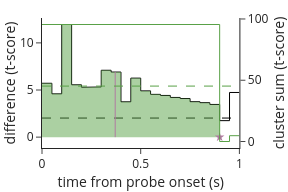

In [84]:
panelname = 't-score'
panelname2 = 'clusters'

def formated_quant(cellid, ctx_pair, probe, panelname, panelname2):
    fig, main_traces, secondary_traces = plot_time_ser_quant(
        cellid, ctx_pair, probe, multiple_comparisons_axis=[1, 2], cluster_threshold=0.05,
        secondary_y=True, meta={'raster_fs':20})

    for trace in main_traces + secondary_traces:
        trace.update(line_width=1, marker_size=7)
    fig.update_traces(line_width=1, marker_size=7)

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(main_traces)

    if panelname2 in panels:
        panels.pop(panelname2)
    panels[panelname2].extend(secondary_traces)

    # test show
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False)
    # fig.show()
    img_bytes = fig.to_image(format="png")
    return Image(img_bytes)

formated_quant(cellid, ctx_pair, probe, panelname, panelname2)

## example 2

In [85]:
# Example 1, same as the one used to define the examples
probe = 4
ctx_pair = [1,3]
cellid = 'ARM021b-36-8'

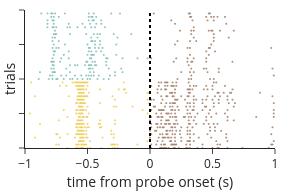

In [86]:
formated_raster(cellid, ctx_pair, probe, 'raster2')

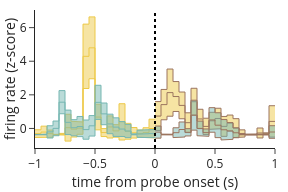

In [87]:
formated_psth(cellid, ctx_pair, probe, 'PSTH2')

using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 2247.50 d'*ms
center of mass: 163.65 ms
last bin: 450.00 ms


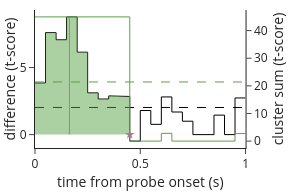

In [88]:
formated_quant(cellid, ctx_pair, probe, 't-score2', 'clusters2')

## example 3
Another neuron in the same site

In [89]:
# Example 1, same as the one used to define the examples
probe = 1
ctx_pair = [2,3]
cellid = 'ARM021b-43-8'

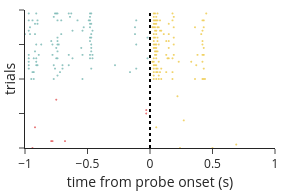

In [90]:
formated_raster(cellid, ctx_pair, probe, 'raster3')

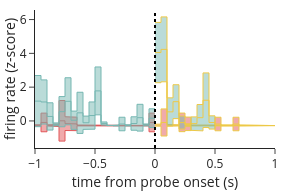

In [91]:
formated_psth(cellid, ctx_pair, probe, 'PSTH3')

using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 1340.58 d'*ms
center of mass: 59.18 ms
last bin: 200.00 ms


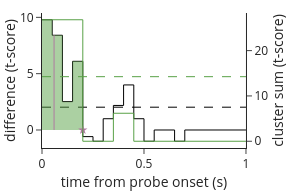

In [92]:
formated_quant(cellid, ctx_pair, probe, 't-score3', 'clusters3')

# Final figure

In [93]:
def define_subplots():
    fig = make_subplots(rows=3, cols=3, vertical_spacing=0.1, horizontal_spacing=0.05,
                        column_width=[1 / 3, 1 / 3, 1 / 3],
                        row_heights=[0.3, 2/6, 2/6],
                        specs=[[{'colspan': 2, 'b':0.05}, None, {}],
                               [{'r':0.0125}, {'l':0.0125}, {'l':0.025,"secondary_y": True}],
                               [{'r':0.0125}, {'l':0.0125}, {'l':0.025,"secondary_y": True}]])
    # figure size in inches at different PPIs
    ppi = 96  # www standard

    heigh = 4
    width = 6  # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=10, b=10),
                          width=round(ppi * width), height=round(ppi * heigh),

                          # sequences
                          xaxis=dict(domain=[0,0.55],
                                     autorange=True,
                                     constrain='range',
                                     tickmode='array',
                                     tickvals=[0,1],
                                     ticktext=[0,1],
                                     showline=False),
                          yaxis=dict(scaleanchor='y2',
                                     autorange=True,
                                     constrain='domain',
                                     tickmode='array',
                                     tickvals=list(range(4)),
                                     ticktext=[f'Seq.{i + 1}' for i in range(4)],
                                     ticks='',
                                     showline=False),

                          # transitions
                          xaxis2=dict(domain=[0.55,1],
                                      constrain='range',
                                      scaleanchor='x',
                                      autorange=True, visible=False),
                          yaxis2=dict(visible=False),

                          # raster1
                          xaxis3=dict(range=[-1,1],
                                      constrain='domain',
                                      showticklabels=False),
                          yaxis3=dict(showticklabels=False,
                                      ticks='',
                                      title_text='trials'),

                          # PSTH1
                          xaxis4=dict(matches='x3',
                                      constrain='domain',
                                      showticklabels=False
                                      ),
                          yaxis4=dict(matches='y8',
                                      autorange=True,
                                      title=dict(text='firing rate (z-score)')),

                          # Quantification 1
                          xaxis5=dict(range=[0,1],
                                      constrain='domain',
                                      showticklabels=False),
                          yaxis5=dict(matches='y9',
                                      autorange=True,
                                      title=dict(text='Difference (T-score)')),
                          yaxis6=dict(matches='y10',
                                      autorange=True,
                                      title=dict(text='Cluster Sum (T-score)',
                                                 font_color=AMPCOLOR)),

                          # raster2
                          xaxis6=dict(matches='x3',
                                      constrain='domain'),
                          yaxis7=dict(showticklabels=False,
                                      ticks=''),

                          # PSTH2
                          xaxis7=dict(matches='x3',
                                      constrain='domain',
                                      title=dict(text='time from probe onset (s)'),),
                          yaxis8=dict(autorange=True,
                                      matches='y4',
                                      ),

                          # Quantification2
                          xaxis8=dict(matches='x5',
                                      constrain='domain'),
                          yaxis9=dict(matches='y5',
                                      autorange=True),
                          yaxis10=dict(matches='y6',
                                       autorange=True),

                          showlegend=False,
                          font_size=10,
                          )
    fig.update_xaxes(title=dict(standoff=0))
    fig.update_yaxes(title=dict(standoff=0))

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 0.6, 1),
        ('c', 0, 0.7),
        ('d', 1/3, 0.7),
        ('e', 2/3, 0.7),
        ('f', 0, 2/6),
        ('g', 1/3, 2/6),
        ('h', 2/3, 2/6),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)

    return fig, round(ppi * width), round(ppi * heigh)


f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
[ (1,1) x,y                 -          ]  [ (1,3) x2,y2     ]
[ (2,1) x3,y3     ]  [ (2,2) x4,y4     ]  [ (2,3) x5,y5,y6  ]
[ (3,1) x6,y7     ]  [ (3,2) x7,y8     ]  [ (3,3) x8,y10,y9 ]



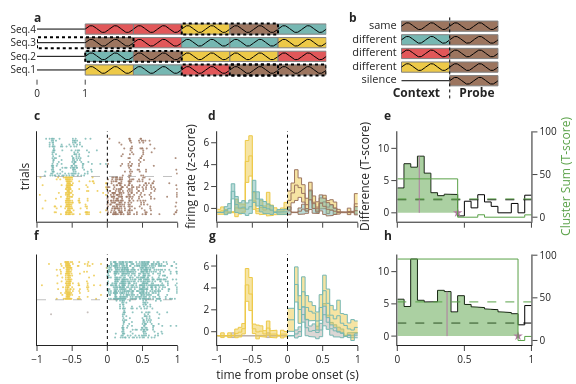

In [94]:
fig, pw, ph = define_subplots()

# top left
pan = panels['sequences']
fig.add_traces(pan, cols=[1] * len(pan), rows=[1] * len(pan))

# top right
pan = panels['transitions']
fig.add_traces(pan, cols=[3] * len(pan), rows=[1] * len(pan))

# middle left
pan = panels['raster2']
fig.add_traces(pan, cols=[1] * len(pan), rows=[2] * len(pan))

# middle midle
pan = panels['PSTH2']
fig.add_traces(pan, cols=[2] * len(pan), rows=[2] * len(pan))

# middle right
pan = panels['t-score2']
fig.add_traces(pan, cols=[3] * len(pan), rows=[2] * len(pan))
# secondary y
pan = panels['clusters2']
fig.add_traces(pan, cols=[3] * len(pan), rows=[2] * len(pan), secondary_ys=[True] * len(pan))

# second example
# bottom left
pan = panels['raster']
fig.add_traces(pan, cols=[1] * len(pan), rows=[3] * len(pan))

# bottom midle
pan = panels['PSTH']
fig.add_traces(pan, cols=[2] * len(pan), rows=[3] * len(pan))

# bottom right
pan = panels['t-score']
fig.add_traces(pan, cols=[3] * len(pan), rows=[3] * len(pan))
# secondary y
pan = panels['clusters']
fig.add_traces(pan, cols=[3] * len(pan), rows=[3] * len(pan), secondary_ys=[True] * len(pan))

# add vertical dashed lines at necesary probe onsets (x=0)
panxy = [(1,3),
         (2,1),
         (2,2),
         (3,1),
         (3,2)]
for rr, cc in panxy:
    _ = fig.add_vline(x=0, line_width=1, line_color='black', line_dash='dot', opacity=1,
                      row=rr, col=cc)

# horizontal lines dividing different context trials in raterss
panxy = [(2,1),
         (3,1)]
for rr, cc in panxy:
    trialn = 20
    _ = fig.add_hline(y=trialn-0.5, line_width=1, line_color='gray', line_dash='dash', opacity=0.5,
                      row=rr, col=cc)

img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)
# fig.show()

In [95]:
# ensures transparent backgrounds
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'figure_01'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))